In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [3]:
from sklearn.model_selection import train_test_split

In [8]:
# folder dataset
happy_folder = "dataset/happy/"
angry_folder = "dataset/angry/"
sad_folder = "dataset/sad/"
neutral_folder = "dataset/neutral/"

limit = 250

In [9]:
# Function to load images and keep track of file names
def load_images_with_filenames(folder, file_extension, limit=None):
    files = glob.glob(folder + file_extension)
    if limit:
        files = files[:limit]
    return [(file, cv2.imread(file)) for file in files]

# Load images and filenames
happy_images = load_images_with_filenames(happy_folder, "*.jpg", limit)
happy_images += load_images_with_filenames(happy_folder, "*.jpeg", limit)

sad_images = load_images_with_filenames(sad_folder, "*.jpg", limit)
sad_images += load_images_with_filenames(sad_folder, "*.jpeg", limit)

angry_images = load_images_with_filenames(angry_folder, "*.jpg", limit)
angry_images += load_images_with_filenames(angry_folder, "*.jpeg", limit)

neutral_images = load_images_with_filenames(neutral_folder, "*.jpg", limit)
neutral_images += load_images_with_filenames(neutral_folder, "*.jpeg", limit)

# Define the images size
common_size = (112, 112)

def resize_images(image_list):
    resized_images = []
    for file_name, image in image_list:
        if image is not None:
            resized_images.append(cv2.resize(image, common_size))
        else:
            print(f"Failed to load image: {file_name}")
    return resized_images

# Resize images and print filenames of None images
images_happy = resize_images(happy_images)
images_sad = resize_images(sad_images)
images_angry = resize_images(angry_images)
images_neutral = resize_images(neutral_images)

libpng warning: iCCP: known incorrect sRGB profile


In [ ]:
# # Use glob to get both .jpg and .jpeg files
# happy_files = glob.glob(happy_folder + "*.jpg") + glob.glob(happy_folder + "*.jpeg")
# angry_files = glob.glob(angry_folder + "*.jpg") + glob.glob(angry_folder + "*.jpeg")
# sad_files = glob.glob(sad_folder + "*.jpg") + glob.glob(sad_folder + "*.jpeg")
# neutral_files = glob.glob(neutral_folder + "*.jpg") + glob.glob(neutral_folder + "*.jpeg")

In [ ]:
# # Now read the images using cv2.imread
# images_happy = [cv2.imread(file) for file in happy_files][:limit]
# images_angry = [cv2.imread(file) for file in angry_files][:limit]
# images_sad = [cv2.imread(file) for file in sad_files][:limit]
# images_neutral = [cv2.imread(file) for file in neutral_files][:limit]

In [10]:
# images labeling
labels_neutral = [0] * len(images_neutral)
labels_happy = [1] * len(images_happy)
labels_angry = [2] * len(images_angry)
labels_sad = [3] * len(images_sad)

In [13]:
# checking data
happy_count = len(images_happy)
angry_count = len(images_angry)
sad_count = len(images_sad)
neutral_count = len(images_neutral)
print(f"happy files : {happy_count}")
print(f"angry files : {angry_count}")
print(f"sad files : {sad_count}")
print(f"neutral files : {neutral_count}")

happy files : 250
angry files : 250
sad files : 250
neutral files : 250


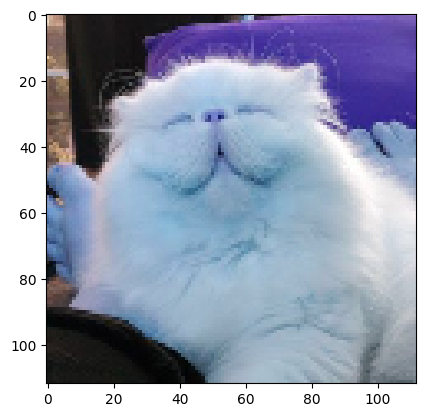

In [17]:
img = np.asarray(images_happy[100])
imgplot = plt.imshow(img)

In [ ]:
# # resize images to 112x112

# common_size = (112,112)
# images_happy = [cv2.resize(image, common_size) for image in images_happy]
# images_angry = [cv2.resize(image, common_size) for image in images_angry]
# images_sad = [cv2.resize(image, common_size) for image in images_sad]
# images_neutral = [cv2.resize(image, common_size) for image in images_neutral]

In [18]:
# Concatenate images and labels
X = np.concatenate((images_neutral, images_happy, images_angry, images_sad), axis = 0)
y = np.concatenate((labels_neutral, labels_happy, labels_angry, labels_sad), axis = 0)

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
X_train.shape

(800, 112, 112, 3)

In [21]:
y_train.shape

(800,)

# VCG16 Model

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

In [26]:
def initialize_vgg16_model():
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

    # Freeze the layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG16 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [27]:
model_vgg16 = initialize_vgg16_model()

In [28]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_vgg16.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 21s 1s/step - loss: 44.7441 - accuracy: 0.3688 - val_loss: 16.7817 - val_accuracy: 0.4812
Epoch 2/25
20/20 [==============================] - 22s 1s/step - loss: 11.9751 - accuracy: 0.6469 - val_loss: 10.6848 - val_accuracy: 0.5437
Epoch 3/25
20/20 [==============================] - 22s 1s/step - loss: 3.8770 - accuracy: 0.7672 - val_loss: 8.1942 - val_accuracy: 0.4938
Epoch 4/25
20/20 [==============================] - 22s 1s/step - loss: 2.0805 - accuracy: 0.8328 - val_loss: 5.7512 - val_accuracy: 0.5562
Epoch 5/25
20/20 [==============================] - 22s 1s/step - loss: 1.0727 - accuracy: 0.8922 - val_loss: 4.8033 - val_accuracy: 0.5562
Epoch 6/25
20/20 [==============================] - 22s 1s/step - loss: 0.6752 - accuracy: 0.9062 - val_loss: 4.5502 - val_accuracy: 0.5625
Epoch 7/25
20/20 [==============================] - 22s 1s/step - loss: 0.8697 - accuracy: 0.9375 - val_loss: 4.6915 - val_accuracy: 0.5625
Epoch 8/25
20/20

In [29]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # ----Loss----
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Validation'], loc= 'best')
    ax[0].grid(axis='x', linewidth=0.5)
    ax[0].grid(axis='y', linewidth=0.5)
    
    # ----Accuracy----
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Train', 'Validation'], loc= 'best')
    ax[1].grid(axis='x', linewidth=0.5)
    ax[1].grid(axis='y', linewidth=0.5)
    
    if title:
        fig.suptitle(title)

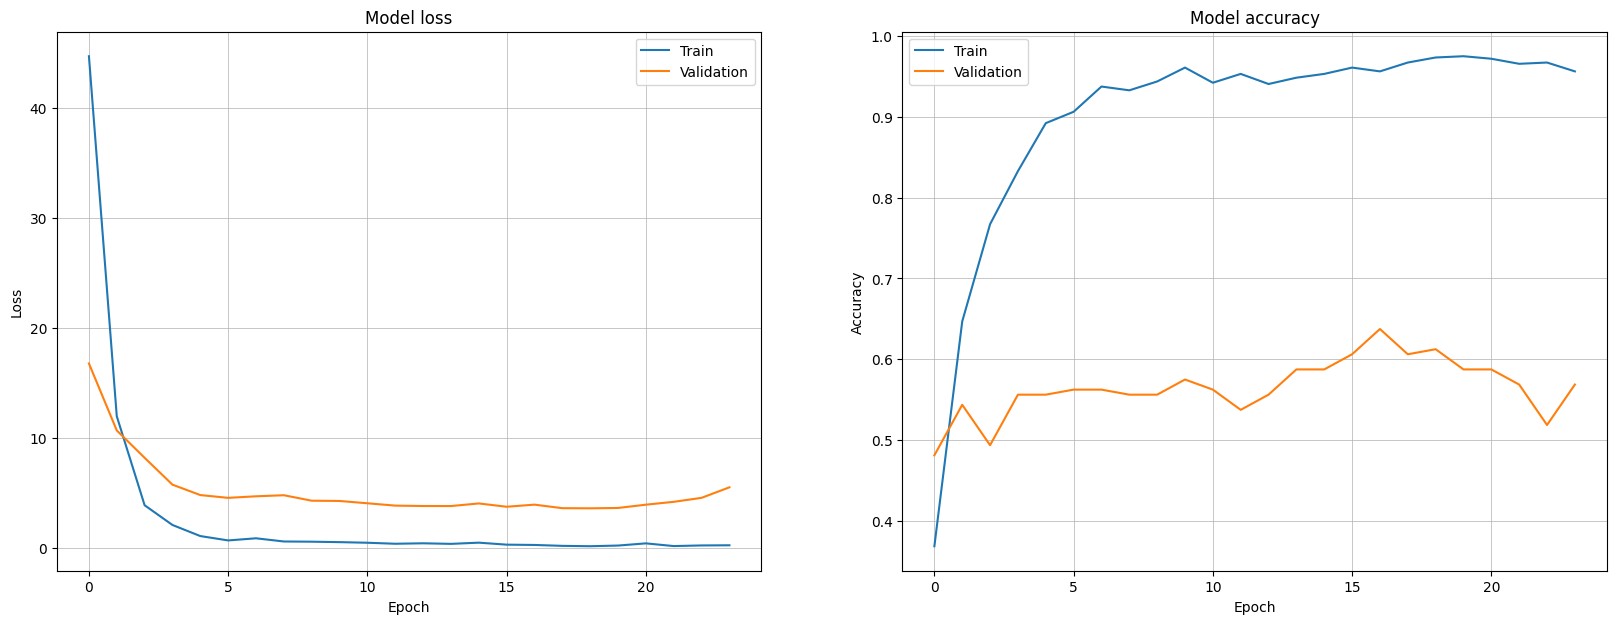

In [30]:
plot_loss_accuracy(history, title=None)

In [31]:
evaluation = model_vgg16.evaluate(X_test, y_test)

7/7 [==============================] - 6s 777ms/step - loss: 5.9787 - accuracy: 0.4950


In [32]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 49.5 %


# VCG19 Model

In [33]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19

In [34]:
def initialize_vgg19_model():
    # Load the pre-trained VGG19 model without the top (fully connected) layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

    # Freeze the layers of the pre-trained VGG19 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG19 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [35]:
model_vgg19 = initialize_vgg19_model()

In [36]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_vgg19.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 29s 1s/step - loss: 43.7638 - accuracy: 0.3609 - val_loss: 17.4522 - val_accuracy: 0.4500
Epoch 2/25
20/20 [==============================] - 30s 2s/step - loss: 6.2811 - accuracy: 0.6938 - val_loss: 8.8696 - val_accuracy: 0.5312
Epoch 3/25
20/20 [==============================] - 31s 2s/step - loss: 1.8907 - accuracy: 0.8391 - val_loss: 7.5230 - val_accuracy: 0.5250
Epoch 4/25
20/20 [==============================] - 32s 2s/step - loss: 0.7578 - accuracy: 0.9234 - val_loss: 6.0307 - val_accuracy: 0.5750
Epoch 5/25
20/20 [==============================] - 33s 2s/step - loss: 0.4999 - accuracy: 0.9375 - val_loss: 5.9209 - val_accuracy: 0.5750
Epoch 6/25
20/20 [==============================] - 36s 2s/step - loss: 0.2564 - accuracy: 0.9703 - val_loss: 6.0579 - val_accuracy: 0.5437
Epoch 7/25
20/20 [==============================] - 40s 2s/step - loss: 0.2178 - accuracy: 0.9625 - val_loss: 6.7401 - val_accuracy: 0.5500
Epoch 8/25
20/20 [

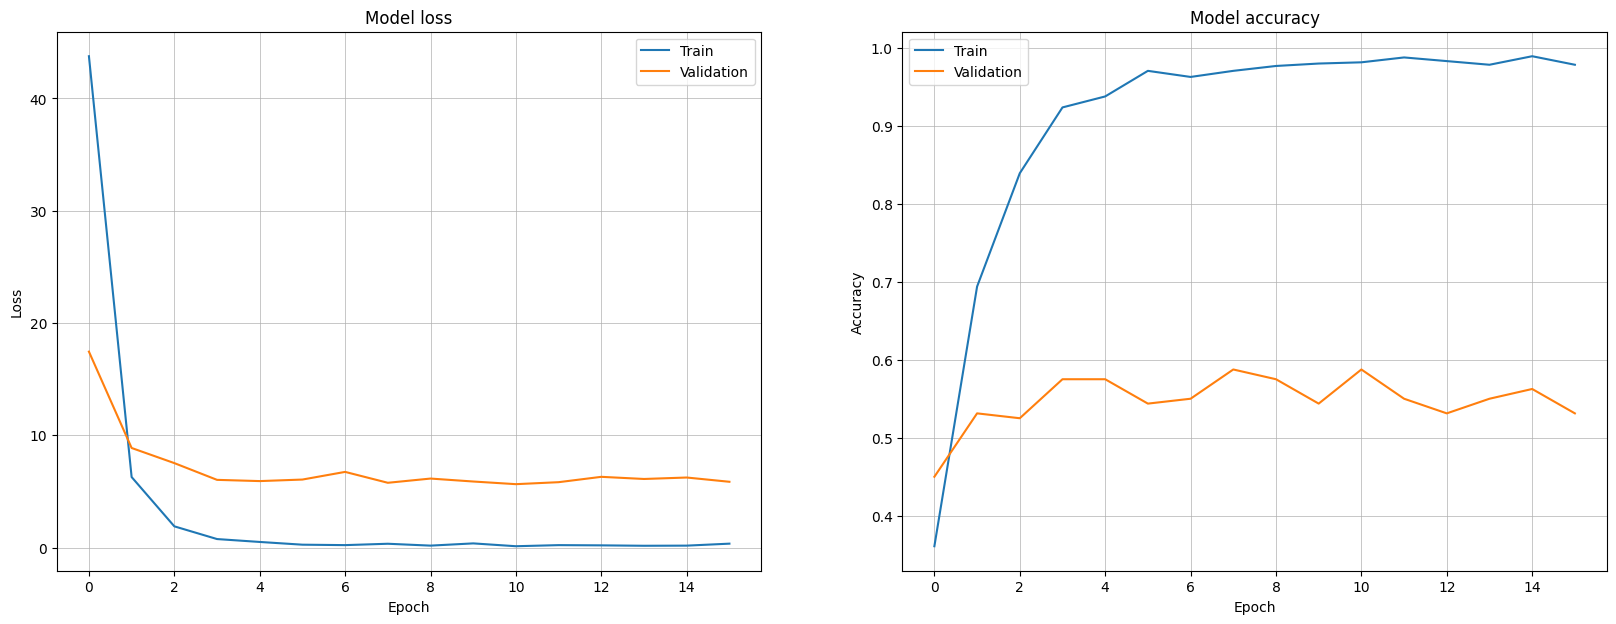

In [37]:
plot_loss_accuracy(history, title=None)

In [38]:
evaluation = model_vgg19.evaluate(X_test, y_test)

7/7 [==============================] - 8s 1s/step - loss: 5.7738 - accuracy: 0.5650


In [39]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 56.5 %


# EfficientNetB3

In [70]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.applications import EfficientNetB7

In [71]:
def initialize_effnetB7_model():
    # Load the pre-trained EfficientNetB7 model without the top (fully connected) layers
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

    # Freeze the layers of the pre-trained EfficientNetB7 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()


    # Add the pre-trained EfficientNetB7 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [72]:
model_effnet = initialize_effnetB7_model()

In [73]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_effnet.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 26s 983ms/step - loss: 9.4727 - accuracy: 0.3031 - val_loss: 2.4416 - val_accuracy: 0.4062
Epoch 2/25
20/20 [==============================] - 17s 871ms/step - loss: 1.4068 - accuracy: 0.4984 - val_loss: 1.3283 - val_accuracy: 0.3562
Epoch 3/25
20/20 [==============================] - 19s 949ms/step - loss: 0.8824 - accuracy: 0.6656 - val_loss: 1.3226 - val_accuracy: 0.4563
Epoch 4/25
20/20 [==============================] - 22s 1s/step - loss: 0.7002 - accuracy: 0.7188 - val_loss: 1.3517 - val_accuracy: 0.4500
Epoch 5/25
20/20 [==============================] - 24s 1s/step - loss: 0.6311 - accuracy: 0.7547 - val_loss: 1.2907 - val_accuracy: 0.4812
Epoch 6/25
20/20 [==============================] - 22s 1s/step - loss: 0.4648 - accuracy: 0.8344 - val_loss: 1.3692 - val_accuracy: 0.4688
Epoch 7/25
20/20 [==============================] - 20s 1s/step - loss: 0.3606 - accuracy: 0.8813 - val_loss: 1.4909 - val_accuracy: 0.4500
Epoch 8/25


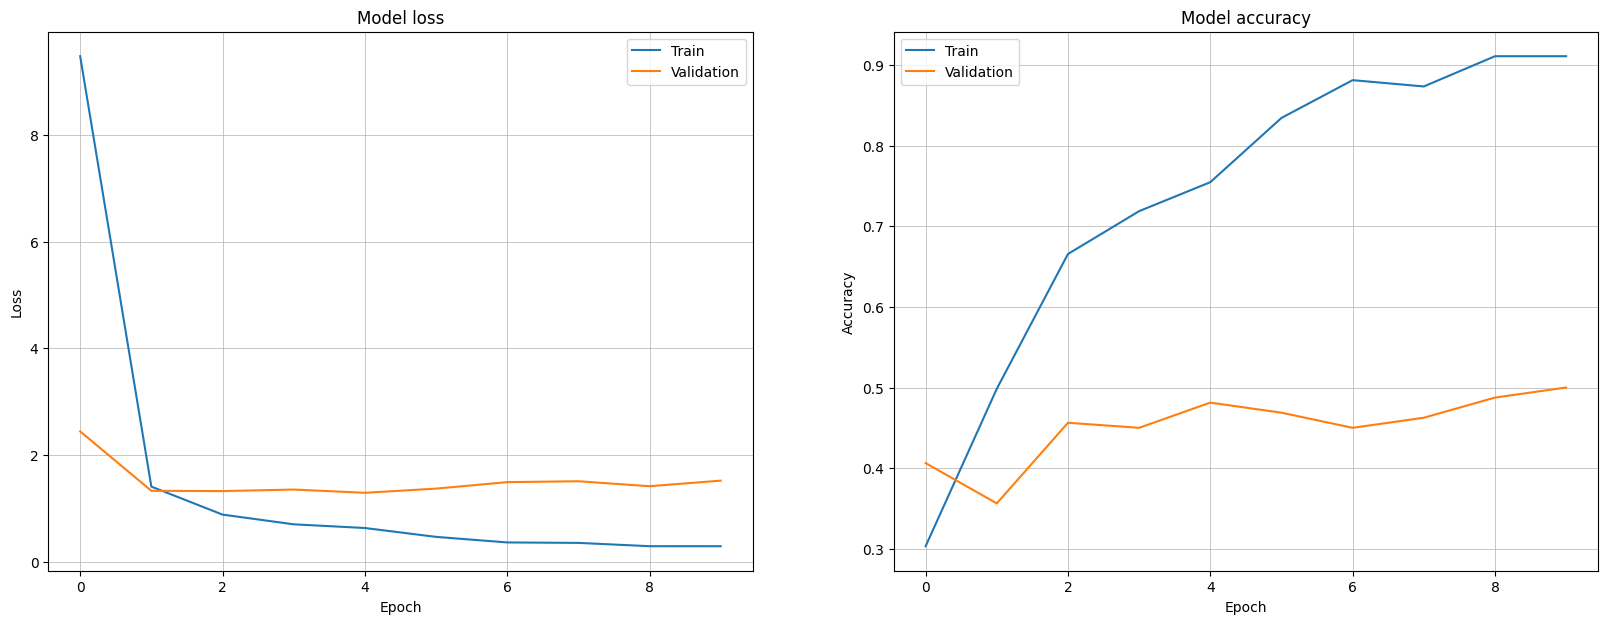

In [74]:
plot_loss_accuracy(history, title=None)

In [75]:
evaluation = model_effnet.evaluate(X_test, y_test)

7/7 [==============================] - 6s 587ms/step - loss: 1.2712 - accuracy: 0.4650


In [76]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 46.5 %


In [ ]:
# Save model
model_vgg16.save("pets_expression_vgg16_86%.h5")

In [ ]:
prediction = model.predict(X_test)

In [ ]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(112, 112))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("pets_expression_vgg16_86%.h5")

In [ ]:
# Replace 'path_to_your_image' with the path to your animal image
img_array = load_and_preprocess_image('dataset/cat_test/kucinggif.jpg')

In [ ]:
# Make a prediction
prediction = model.predict(img_array)

In [ ]:
# Decode the prediction
emotion = np.argmax(prediction)
emotions = ['Neutral', 'Happy', 'Angry', 'Sad']
predicted_emotion = emotions[emotion]

print("Predicted Emotion:", predicted_emotion)